### Mateusz Kądziela, 148271
### Mateusz Serek, 148284
Source code and more readable pseudocode available [here](https://github.com/MatKadd/EC_2023/tree/main/lab6).

In [1]:
import pandas as pd
import time
import numpy as np
from prettytable import PrettyTable 
from numba.typed import List

In [2]:
from visualizations import visualize_solution, visualize_stats
from utils import calculate_distances, evaluate_solution
from algorithms import get_random_solution, get_edge_neigh, steepest, del_and_fill

# Read data and calculate distances

In [3]:
C = pd.read_csv("../data/TSPC.csv", sep=";", header=None)
C.name = "Instance C"

instances = [C]

In [4]:
distances = calculate_distances(C)

# As stated in the task, we used neighborhood with edge exchange, random starting solution and steepest local search.

First, we will run MSLS and compute average run time for ILS.

In [5]:
def local_search(solution, neigh_type, distances):
    while True:
        neigh = neigh_type(solution)
        solution, improvement = steepest(solution, neigh, distances)
        if improvement == 0:
            break
    return solution

In [6]:
def MSLS(start_solution, neigh_type, distances, n=200):
    start_solutions = [start_solution(start_node=_) for _ in range(n)]
    final_solutions = []
    for solution in start_solutions:
        final_solution = local_search(solution, neigh_type, distances)
        final_solutions.append((final_solution, evaluate_solution(final_solution, distances)))
    return min(final_solutions, key=lambda solution: solution[1])

Min score for MSLS: 48599
Max score for MSLS: 49524
Avg score for MSLS: 49116.5


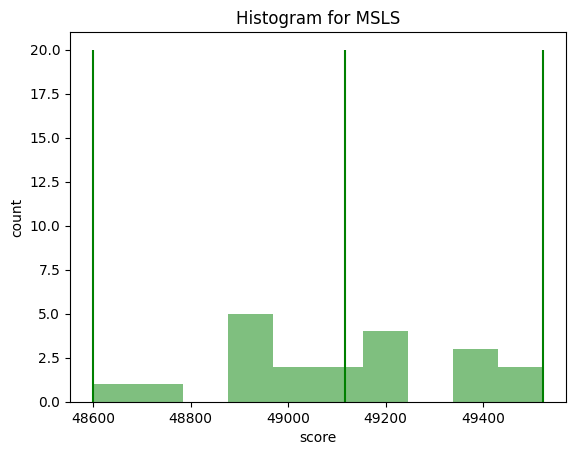

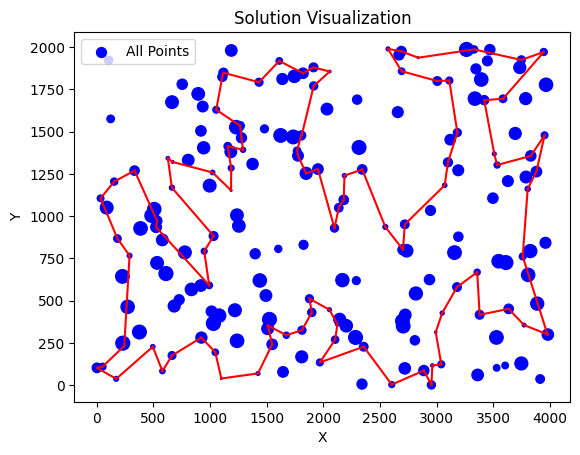

In [7]:
solutions = []
total_time = 0

for i in range(20):
    start = time.perf_counter()
    solution, score = MSLS(get_random_solution, get_edge_neigh, distances)
    end = time.perf_counter()
    total_time += (end-start)
    solutions.append((solution, score))

avg_time = total_time / 20
scores = [solution[1] for solution in solutions]
msls_avg_score = np.mean(scores)
visualize_stats(scores, 'MSLS')
visualize_solution(C, min(solutions, key=lambda solution: solution[1])[0])

Now, we will run ILS with runtime limited to the average running time of MSLS. Our perturbation in ILS is pretty simple. It goes over the solution and randomly removes nodes from it. Then it goes over the solution again and fills the deleted nodes, with nodes closest to the node before it in the solution.

In [8]:
def ILS(start_solution, neigh_type, perturbation, distances):
    start = time.perf_counter()
    solution = start_solution()
    solution = local_search(solution, neigh_type, distances)
    current_score = evaluate_solution(solution, distances)
    count = 1
    while (time.perf_counter()-start < avg_time):
        new_solution = perturbation(solution, distances)
        new_solution = local_search(new_solution, neigh_type, distances)
        count += 1
        score = evaluate_solution(new_solution, distances)
        if score < current_score:
            current_score = score
            solution = new_solution
    return solution, current_score, count

Min score for ILS: 46883
Max score for ILS: 47979
Avg score for ILS: 47282.55


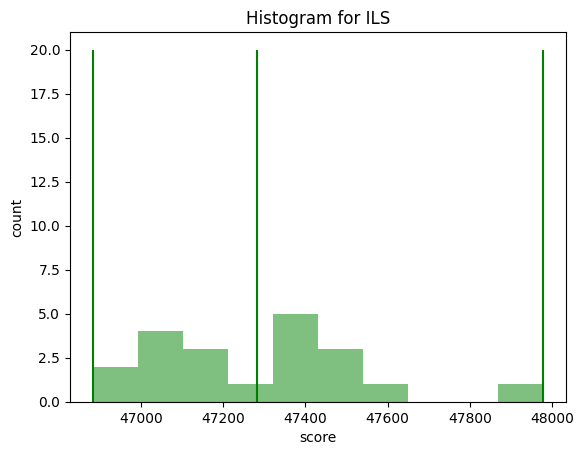

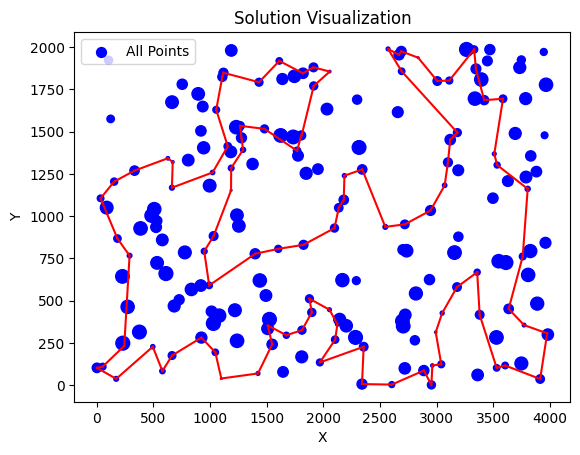

In [9]:
solutions = []

for i in range(20):
    solution, score, count = ILS(get_random_solution, get_edge_neigh, del_and_fill, distances)
    solutions.append((solution, score, count))

scores = [solution[1] for solution in solutions]
ils_avg_score = np.mean(scores)
visualize_stats(scores, 'ILS')
visualize_solution(C, min(solutions, key=lambda solution: solution[1])[0])

In [10]:
counts = [solution[2] for solution in solutions]
avg_counts = np.mean(counts)
print(f"Average amount of calls to local search function for one solution: {avg_counts}")

Average amount of calls to local search function for one solution: 3246.75


In [11]:
table = PrettyTable(["Method", "Avg time for one solution", "Avg score for method"]) 
table.add_row(['MSLS', avg_time, msls_avg_score])
table.add_row(['ILS', avg_time, ils_avg_score])
print(table)

+--------+---------------------------+----------------------+
| Method | Avg time for one solution | Avg score for method |
+--------+---------------------------+----------------------+
|  MSLS  |     13.979888224997557    |       49116.5        |
|  ILS   |     13.979888224997557    |       47282.55       |
+--------+---------------------------+----------------------+


# Conclusions

When comparing both approaches, it is clear that ILS is better than MSLS. In the same amount of time, it provides slightly better results. The results have met our expectations. ILS could probably be imporved even more, by checking results for different probability of deleting nodes in perturbation or even create a better way to perturb the solution.